# Classical Data Preprocessing and Conformal Transform

In this notebook, we accept 3D hits data from the TrackML dataset and treat using the Classical Hough Transform. The initial code of the notebook can be adapted to use with Quantum Hough Transform algorithm.

Note: Reqires installation of trackml-library. Can use the following in the Anaconda environment.

conda install git pip
pip install git+git://github.com/scrappy/scrappy@master

## Classical Hough Transform for single event from TrackML Dataset

In [4]:
# import necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys

from trackml.dataset import load_event, load_dataset
from trackml.utils import add_position_quantities, add_momentum_quantities, decode_particle_id
from trackml.randomize import shuffle_hits
from trackml.score import score_event

import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
#import seaborn as sns
#%matplotlib inline

In [7]:
hits, cells, particles, truth = load_event('../TrackML_100_events_dataset/event000001000')
print(hits)
#hits.head()
def cartesian_to_cylindrical(x, y, z):
    
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    z = z
    return r, phi, z


def create_hough_matrix(hits):
    
    hough_matrix = hits[['hit_id', 'x', 'y', 'z']].copy()
    hough_matrix.columns = ['HitID', 'X', 'Y', 'Z']
    
    r, phi, z = cartesian_to_cylindrical(hough_matrix['X'].values, 
                                         hough_matrix['Y'].values, 
                                         hough_matrix['Z'].values)

    hough_matrix['R'] = r
    hough_matrix['Phi'] = phi
    
    # Pandas dataframe values to array
    trx1 = hough_matrix['R'].values
    try1 = hough_matrix['Phi'].values 
    trx2 = hough_matrix['X'].values
    try2 = hough_matrix['Y'].values 
    
    #plot to check mapping
    
    plt.scatter(hough_matrix['X'].values,hough_matrix['Y'].values)
    #plt.scatter(trx2[0:500],try2[0:500])
    #plt.scatter([trx2[0],trx2[2],trx2[3],trx2[4],trx2[6],trx2[8],trx2[9]],
    #            [try2[0],try2[2],try2[3],try2[4],try2[6],try2[8],try2[9]])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    
    plt.scatter(hough_matrix['R'].values,hough_matrix['Phi'].values)
    #plt.scatter(trx1[0:500],try1[0:500])
    #plt.scatter([trx1[0],trx1[2],trx1[3],trx1[4],trx1[6],trx1[8],trx1[9]],
    #            [try1[0],try1[2],try1[3],try1[4],try1[6],try1[8],try1[9]])
    plt.xlabel('R')
    plt.ylabel('Phi')
    plt.show()
    
    #return the hough matrix --- basically the hits matrix with Phi and R values appended.
    return hough_matrix

        hit_id           x          y       z  volume_id  layer_id  module_id
0            1  -64.409897  -7.163700 -1502.5          7         2          1
1            2  -55.336102   0.635342 -1502.5          7         2          1
2            3  -83.830498  -1.143010 -1502.5          7         2          1
3            4  -96.109100  -8.241030 -1502.5          7         2          1
4            5  -62.673599  -9.371200 -1502.5          7         2          1
...        ...         ...        ...     ...        ...       ...        ...
120934  120935 -763.862976  51.569401  2944.5         18        12         97
120935  120936 -808.705017   3.459260  2944.5         18        12         97
120936  120937 -982.935974  41.460899  2952.5         18        12         98
120937  120938 -942.698975  18.489100  2952.5         18        12         98
120938  120939 -922.890015   2.092850  2952.5         18        12         98

[120939 rows x 7 columns]


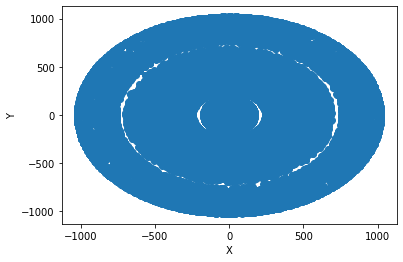

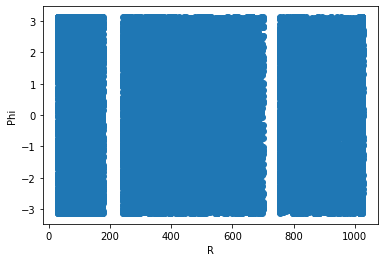

CPU times: user 4.01 s, sys: 38 ms, total: 4.05 s
Wall time: 1.33 s


In [6]:
%%time 
hits_updated = create_hough_matrix(hits)

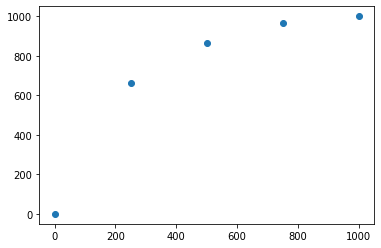

In [17]:
#######################################################
## Plotting the discretized circular tracks
#######################################################

#x = np.linspace(-1000,1000,10000) # 100 linearly spaced numbers
x = []
for i in range(2001):
    x.append(i)
y=[]
for i in range(2001):
    y.append(np.sqrt(np.absolute(-(x[i]-1000)**2 + 1000000)))
#y = np.sqrt(-x**2 + 36) # computing the values of sin(x)/x
#plt.scatter(x,y) # sin(x)/x
plt.scatter([x[0],x[250],x[500],x[750],x[1000]],[y[0],y[250],y[500],y[750],y[1000]])
#pylab.plot(x,y,'co',label="cyan dots") # same function with cyan dots
#pylab.plot(x,2*y,x,3*y,label="other plot") # 2*sin(x)/x and 3*sin(x)/x
plt.show() # show the plot

## Track Forming and Visualization 5 layer tracks + Conformal Transform

The following is a toy model detector generating circular tracks in 2D, and detected accross 5 layers.

[0.0, 580.9475019311126, 741.6198487095663, 798.4359711335655, 774.5966692414834]


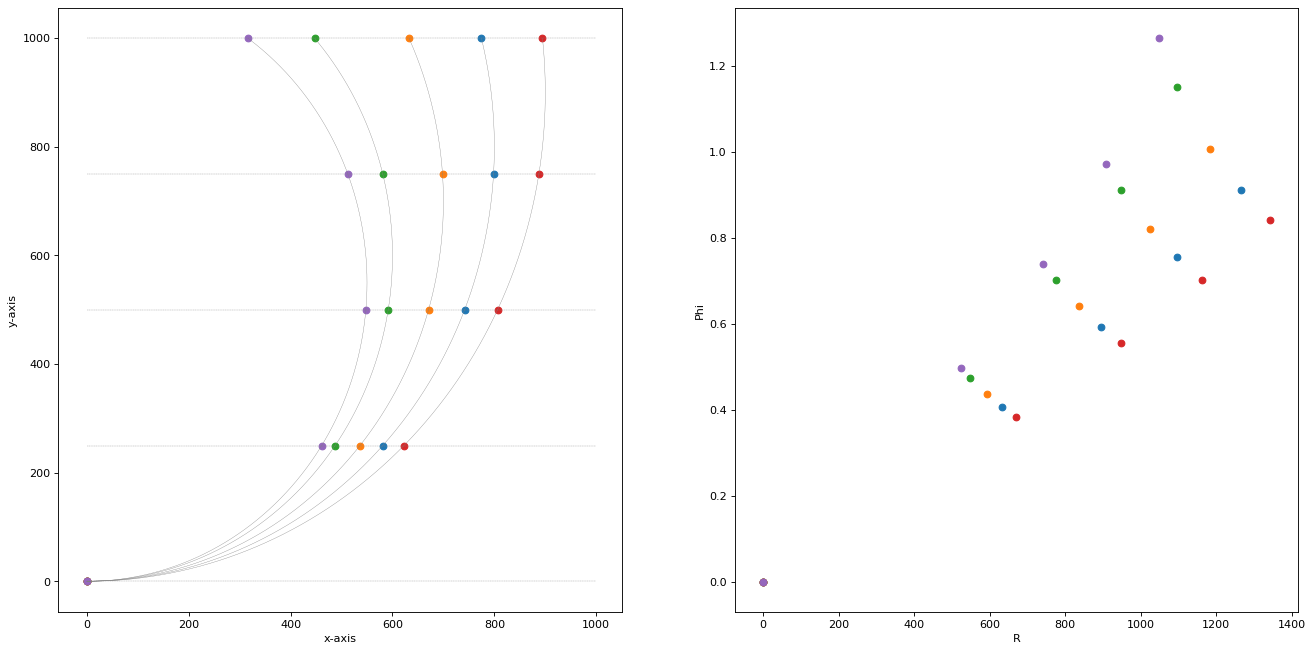

In [2]:
##############################################################################
### Function: Necessary Imports
##############################################################################

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

##############################################################################
### Function: Generate 2D tracks for a toy model detector with 5 layers
##############################################################################

y = []
for i in range(1001):
    y.append(i)
    
c = []
for i in range(1001):
    c.append(i)
    
def create_detector():
    detect_line_0 = []  
    detect_line_250 = []  
    detect_line_500 = []  
    detect_line_750 = [] 
    detect_line_1000 = [] 
    
    for i in range(1001):
        detect_line_0.append(0)
        detect_line_250.append(250)
        detect_line_500.append(500)
        detect_line_750.append(750)
        detect_line_1000.append(1000)
        
    #Setting plot figure size
    figure(num=None, figsize=(20,10), dpi=80)
    
    ################# Plot Detector Grid Lines #################
    plt.subplot(121)    
    plt.plot(y,detect_line_0,'--',color='gray',linewidth=0.3)
    plt.plot(y,detect_line_250,'--',color='gray',linewidth=0.3)
    plt.plot(y,detect_line_500,'--',color='gray',linewidth=0.3)
    plt.plot(y,detect_line_750,'--',color='gray',linewidth=0.3)
    plt.plot(y,detect_line_1000,'--',color='gray',linewidth=0.3)
    #############################################################

def main():
    create_detector()
    #initialize empty arrays
    x1,x2,x3,x4,x5 = [],[],[],[],[]
    d1 = []
    
    #equation of circle, x**2 + y**2 = r**2
    # x = sqrt((y-y_i)**2 + r**2)
    for i in range(1001):
        x1.append(np.sqrt(np.absolute(-(y[i]-800)**2 + 640000))) #equation of circle, x**2 + y**2 = r**2
        x2.append(np.sqrt(np.absolute(-(y[i]-700)**2 + 490000)))
        x3.append(np.sqrt(np.absolute(-(y[i]-600)**2 + 360000)))
        x4.append(np.sqrt(np.absolute(-(y[i]-900)**2 + 810000)))
        x5.append(np.sqrt(110*y[i]))
        d1.append(np.sqrt(np.absolute(-(c[i]-550)**2 + 302500)))
    
    track_1 = [x1[0],x1[250],x1[500],x1[750],x1[1000]] #top circle
    track_2 = [x2[0],x2[250],x2[500],x2[750],x2[1000]]
    track_3 = [x3[0],x3[250],x3[500],x3[750],x3[1000]]
    track_4 = [x4[0],x4[250],x4[500],x4[750],x4[1000]]
    track_5 = [x5[0],x5[250],x5[500],x5[750],x5[1000]] #parabola
    track_6 = [d1[0],d1[250],d1[500],d1[750],d1[1000]] #right circle
    layer_coordinates = [y[0],y[250],y[500],y[750],y[1000]]
    
    #plt.scatter(x5,y,color='red',linewidth=1.0) #where x=1,2,3...n for n number of tracks
    print(track_1)
    plt.scatter(track_1,layer_coordinates) #circular
    plt.scatter(track_2,layer_coordinates) #circular
    plt.scatter(track_3,layer_coordinates) #circular
    plt.scatter(track_4,layer_coordinates) #circular
    #plt.scatter(track_5,layer_coordinates) #parabola
    plt.scatter(track_6, layer_coordinates) #right circle

    ### Overlay Tracks (optional)
    plt.plot(x1,y,color='gray',linewidth=.3)
    plt.plot(x2,y,color='gray',linewidth=.3)
    plt.plot(x3,y,color='gray',linewidth=.3)
    plt.plot(x4,y,color='gray',linewidth=.3)
    #plt.plot(x5,y,color='gray',linewidth=.3)
    plt.plot(d1,y,color='gray',linewidth=.3)
    ### Overlay Track ENDS 

    plt.xlabel('x-axis')
    plt.ylabel('y-axis')

    #print(x3[750],x3[1000])
    #plt.show() # show the plot
    
    ##############################################################################
    # Function: Cartesian to Cylindrical Transform
    ##############################################################################

    r1, phi1 = [], []
    r2, phi2 = [], []
    r3, phi3 = [], []
    r4, phi4 = [], []
    r5, phi5 = [], []

    def cartesian_to_cylindrical_r(x, y):
        r = np.sqrt(x**2 + y**2)
        return r

    def cartesian_to_cylindrical_phi(x,y):
        phi = np.arctan2(y, x)
        return phi

    for n in range(5):
        r1.append(cartesian_to_cylindrical_r(track_1[n],layer_coordinates[n]))
        phi1.append(cartesian_to_cylindrical_phi(track_1[n],layer_coordinates[n]))
        r2.append(cartesian_to_cylindrical_r(track_2[n],layer_coordinates[n]))
        phi2.append(cartesian_to_cylindrical_phi(track_2[n],layer_coordinates[n]))
        r3.append(cartesian_to_cylindrical_r(track_3[n],layer_coordinates[n]))
        phi3.append(cartesian_to_cylindrical_phi(track_3[n],layer_coordinates[n]))
        r4.append(cartesian_to_cylindrical_r(track_4[n],layer_coordinates[n]))
        phi4.append(cartesian_to_cylindrical_phi(track_4[n],layer_coordinates[n]))
        r5.append(cartesian_to_cylindrical_r(track_6[n],layer_coordinates[n]))
        phi5.append(cartesian_to_cylindrical_phi(track_6[n],layer_coordinates[n]))

    #print(r1)
    #print(phi1)
    plt.subplot(122)
    plt.scatter(r1,phi1)
    plt.scatter(r2,phi2)
    plt.scatter(r3,phi3)
    plt.scatter(r4,phi4)
    plt.scatter(r5,phi5)
    #plt.plot(r1,phi1)
    plt.xlabel('R')
    plt.ylabel('Phi')
    plt.show()
  
if __name__== "__main__":
  main()

## Fixed Code for Quantum Hough + 4 Circular Tracks

The following code implements the Quantum Hough Transform to reconstruct 4 circular tracks.